In [1]:
import rushd as rd
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from textwrap import wrap
from statannotations.Annotator import Annotator

import warnings
warnings.filterwarnings("ignore",category=UserWarning)
warnings.filterwarnings("ignore",category=FutureWarning)

In [2]:
experimentdir1 = rd.datadir/'flow'/'2024.07.22_PMA_4dpi_14dpi'
experimentdir2 = rd.datadir/'flow'/'2024.09.09_PMA_CTV_4dpi'
experimentdir3 = rd.datadir/'flow'/'2024.11.04_PMA_CTV'

outputdir = rd.rootdir/'figures'/'PMA_CTV'

In [3]:
#rd.plot.plot_well_metadata(experimentdir3/'metadata.yaml')


# Load Data

In [4]:
data_columns = ['CTV-CellTrace™ Violet-A']

df1 = rd.flow.load_csv_with_metadata(data_path=experimentdir1/'csv_4dpi',yaml_path=experimentdir1/'metadata.yaml',columns=data_columns)
df2 = rd.flow.load_csv_with_metadata(data_path=experimentdir2/'csv',yaml_path=experimentdir2/'metadata.yaml',columns=data_columns)
df3 = rd.flow.load_csv_with_metadata(data_path=experimentdir3/'csv',yaml_path=experimentdir3/'metadata.yaml',columns=data_columns)

df1['rep'] = '2024.07.22'
df2['rep'] = '2024.09.09'
df3['rep'] = '2024.11.04'

df1 = df1[df1['well'] != 'C11'] # sample prep error

df = pd.concat([df1, df2,df3])

In [5]:
df=df.rename(columns={'CTV-CellTrace™ Violet-A':'CTV-A'})
df['condition'] = df['infection'] + ' ' + df['concentration']

Get rid of negative values

In [6]:
data_columns = ['CTV-A']

for i in np.arange(0,np.size(data_columns)):
    df = df.loc[df[data_columns[i]]>0]
    

# CTV gate

In [7]:
CTV_gates = {}

for i in df.rep.unique():
    CTV_gates[i] = df[(df['infection'] == 'Puro') & (df['rep'] == i)]['CTV-A'].quantile(0.2)


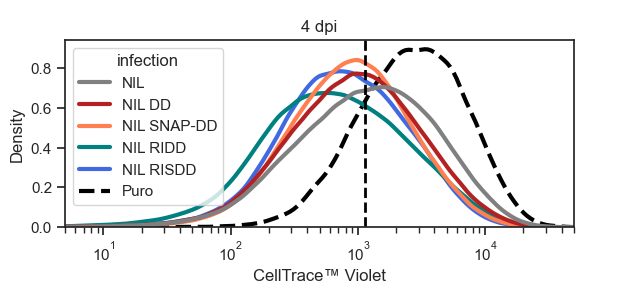

In [11]:
sns.set_theme(style="ticks",font_scale=1)

order = ['NIL','NIL DD','NIL SNAP-DD','NIL RIDD','NIL RISDD','Puro']

palette = {'Puro':'black',
           'NIL':'grey',
           'NIL DD':'firebrick',
           'NIL SNAP-DD':'coral',
           'NIL RIDD':'teal',
           'NIL RISDD':'royalblue'}

fig = plt.figure(figsize=(6,3))
g = sns.kdeplot(data=df[(df['rep'] == '2024.09.09')],x='CTV-A',hue='infection',log_scale=True,common_norm=False,linewidth=3,palette=palette,hue_order=order)
plt.axvline(x=CTV_gates['2024.09.09'],linestyle='--',color='black',linewidth=2)

# Make No Color have a dashed linestyle
lss = reversed(['-', '-', '-','-','-', '--'])
handles = g.legend_.legend_handles[::-1]
for line, ls, handle in zip(g.lines, lss, handles):
    line.set_linestyle(ls)
    handle.set_ls(ls)

fig.legend(bbox_to_anchor=(1, 1), loc='upper left', frameon=False)
plt.xlim([5,5*10**4])
plt.title('4 dpi')
plt.xlabel('CellTrace™ Violet')
fig.tight_layout()
plt.show()

In [12]:
groups = ['rep','infection','concentration','condition','well'] # 'rep' must be first group!!!!


def percent_hyperP(x):
    rep = x.name[0]  # Assuming 'rep' is the first group
    gate_value = CTV_gates[rep]
    return np.mean(x < gate_value) * 100

def total_hyperP(x):
    rep = x.name[0]  # Assuming 'rep' is the first group
    gate_value = CTV_gates[rep]
    return np.sum(x < gate_value)

# Create the summary dataframe
summary_df = pd.concat([
    df.groupby(groups)['CTV-A'].apply(percent_hyperP).rename('(%) HyperP'),
    df.groupby(groups)['CTV-A'].apply(total_hyperP).rename('(#) Total HyperP'),
    df.groupby(groups)['CTV-A'].apply(lambda x: np.size(x)).rename('Total Cell Count'),
], axis=1)
summary_df = summary_df.reset_index()

data2plot = ['(%) HyperP','(#) Total HyperP','Total Cell Count']

# Plotting Functions

In [13]:
def custom_barplot(x,y,data,filename,height=4,width=8,hue=None,xlabel_rot=90,xlabel='',plottitle='',palette='viridis',order=None,hue_order=None,pairs=None,alpha=0.8,reps=None):
    aspect = width / height
    g = sns.catplot(x=x,y=y,data=data,height=height,aspect=aspect,palette=palette,kind='bar',hue=hue,order=order,hue_order=hue_order,alpha=alpha,errorbar='ci',legend=None)
    ax = plt.gca()
    
    if order != None:
        #labels = [ '\n'.join(wrap(l, 4)) for l in order]
        labels = [ '\n'.join(l.split(' ')) for l in order]
    else:
        labels = None

    if hue == None:
        dodge = False
    elif hue != None:
        dodge = True

    if reps is None:
        g.map_dataframe(sns.stripplot, x=x,y=y, 
                    hue=hue, palette=["#404040"], 
                    alpha=0.8, dodge=dodge,order=order,hue_order=hue_order)
    
    marker_list = ['o', '^', 's', 'D', 'P', 'X']

    if reps is not None:
        for (j, rep) in enumerate(data[reps].unique()):
            sns.stripplot(
                ax=ax, data=data[data[reps] == rep],
                x=x, y=y,
                order=order,
                hue=hue,
                hue_order=hue_order,
                dodge=dodge, marker=marker_list[j],
                palette=['white'], size=5,
                edgecolor='black', linewidth=0.4,
                legend=None)

    if pairs != None:
        annotator = Annotator(ax,pairs,data=data,x=x,y=y,order=order,hue=hue,hue_order=hue_order)
        annotator.configure(test='t-test_ind',text_format='star',loc='inside', verbose=2)
        annotator.apply_and_annotate()
        #add_stat_annotation(ax, data=data, x=xcat, y=ycat, order=order,
        #            box_pairs=pairs,
        #            test='t-test_ind', text_format='star', verbose=2)

    ymin, ymax = ax.get_ylim()
    if ymax > 1000:
        k_formatter = matplotlib.ticker.FuncFormatter(lambda x, _: f'{x:.0f}' if abs(x) < 1000 else f'{x/1000:.0f}k')
        ax.yaxis.set_major_formatter(k_formatter)

    sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False) # make plot bounded on all sides
    
    g.set_xticklabels(labels,rotation=xlabel_rot, horizontalalignment='center' if xlabel_rot==0 else 'right')
    plt.xlabel(xlabel)
    plt.ylabel(y)
    plt.title(plottitle)

    if hue is not None:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0, frameon=False)  # Adjust bbox_to_anchor as needed

    plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.25) # make all plots have the same area
    #g.tight_layout()
    g.savefig(outputdir/str(filename + '.svg'),dpi=300)



def custom_catplot(xcat,ycat,dataslice,savetitle,height=4,width=8,xlabel_rot=0,xlabel='',plottitle='',order=None,palette=None,pairs=None):
    if palette != None:
        hue = xcat
        color = None
    elif palette == None:
        hue = None
        color = '#000000'
    aspect = width / height
    g = sns.catplot(x=xcat,y=ycat,data=dataslice,height=height,aspect=aspect,zorder=1,palette=palette,order=order,hue=hue,color=color,s=70)
    g.map_dataframe(sns.pointplot, x=xcat,y=ycat,errorbar='se',join=False,capsize=0.22,ax=g.ax,palette=palette,markers='_',scale=1.5,errwidth=1.5,order=order,hue=hue,color=color)
    #sns.pointplot(x=xcat,y=ycat,data=dataslice,errorbar='se',join=False,capsize=0.22,ax=g.ax,palette=palette,markers='_',scale=1.5,errwidth=1.5,order=order,hue=hue,color=color)
    ax = plt.gca()
    
    #plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))  # this is for if you want scientific y axis labels (e.g. 10^4 instead of 10000)
    if order != None:
        #labels = [ '\n'.join(wrap(l, 16)) for l in order]
        labels = [ '\n'.join(l.split(' ')) for l in order]
    else:
        labels = None

    if pairs != None:
        annotator = Annotator(g.ax,pairs,data=dataslice,x=xcat,y=ycat,order=order)
        annotator.configure(test='Kruskal',text_format='star',loc='inside')
        annotator.apply_and_annotate()

    ymin, ymax = ax.get_ylim()
    if ymax > 1000:
        plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

    #sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
    plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.25) # make all plots have the same area
    g.set_xticklabels(labels,rotation=xlabel_rot, horizontalalignment='center' if xlabel_rot==0 else 'right')
    g.tight_layout()
    plt.legend([],[], frameon=False)
    plt.xlabel(xlabel)
    plt.ylabel(ycat)
    plt.title(plottitle)
    
    g.savefig(outputdir/str(savetitle + '.png'),dpi=300)
    g.savefig(outputdir/str(savetitle + '.svg'),dpi=300)

def custom_hist(xcat,data,order,hue,savetitle=None,palette='muted',gate=None,xlim=[10,5*10**4]):
    plt.figure(figsize=(8,4))
    if xcat in ['FSC-A','FSC-H']:
        log = False
        plt.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
    else:
        log = True
    g = sns.kdeplot(data=data,x=xcat,hue=hue,log_scale=log,common_norm=False,hue_order=order,palette=palette, linewidth=2.5,fill=True,alpha=0.08)

    if gate is not None:
        plt.axvline(x=gate,linestyle='--',color='black',linewidth=2.5)

    sns.move_legend(g, loc='upper left', bbox_to_anchor=(1,1), frameon=False)
    plt.xlim(xlim)
    plt.title('4 dpi')
    plt.xlabel(xcat)
    plt.tight_layout()
    #g.savefig(outputdir/str(savetitle + '.png'),dpi=300)
    g.savefig(outputdir/str(savetitle + '.svg'),dpi=300)


# Plot Results

In [14]:
reps2plot = [#'2024.07.01',
              '2024.07.22', '2024.09.09','2024.11.04']
dataslice = summary_df[summary_df['rep'].isin(reps2plot)]

palette_PMA = {'0 nM':'grey','100 nM':'#cc75ab'}

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL DD_0 nM vs. NIL DD_100 nM: t-test independent samples, P_val:6.003e-04 t=-4.259e+00
NIL_0 nM vs. NIL_100 nM: t-test independent samples, P_val:2.018e-02 t=-2.579e+00
NIL SNAP-DD_0 nM vs. NIL SNAP-DD_100 nM: t-test independent samples, P_val:1.312e-06 t=-7.480e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL DD_0 nM vs. NIL DD_100 nM: t-test independent samples, P_val:1.461e-05 t=-6.126e+00
NIL_0 nM vs. NIL_100 nM: t-test independent samples, P_val:5.700e-03 t=-3.190e+00
NIL SNAP-DD_0 nM vs. NIL SNAP-DD_100 nM: t-test independent samples, P_val:1.248e-09 t=-1.242e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-

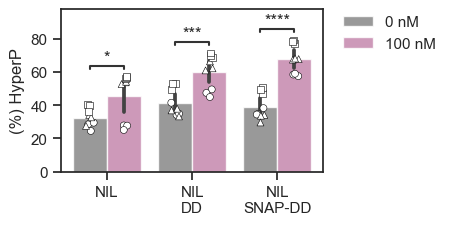

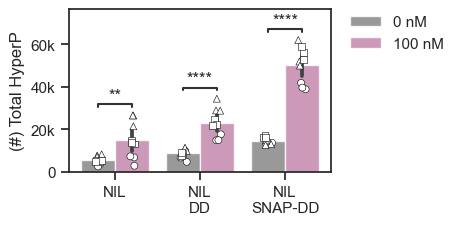

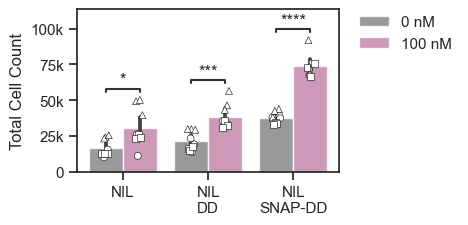

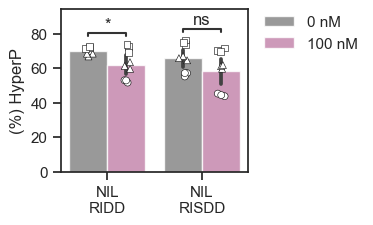

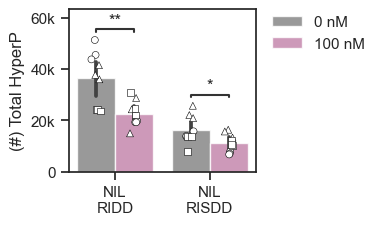

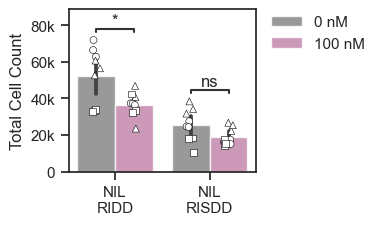

In [15]:
order = ['NIL','NIL DD','NIL SNAP-DD']
pairs = [(('NIL', '0 nM'),('NIL','100 nM')),
          (('NIL DD', '0 nM'),('NIL DD','100 nM')),
          (('NIL SNAP-DD', '0 nM'),('NIL SNAP-DD','100 nM'))]

for i in data2plot:
    savetitle = '100nM_DD_' + i
    custom_barplot('infection',i,dataslice,savetitle,
                    order = order,
                    hue = 'concentration',
                    hue_order=['0 nM','100 nM'],
                    palette=palette_PMA,
                    height=2.5,
                    width=3.5,
                    xlabel_rot=0,
                    alpha=0.8,
                    reps='rep',
                    pairs=pairs)


order = ['NIL RIDD','NIL RISDD']
pairs = [(('NIL RIDD', '0 nM'),('NIL RIDD','100 nM')),
          (('NIL RISDD', '0 nM'),('NIL RISDD','100 nM'))]

for i in data2plot:
    savetitle = '100nM_RAS_' + i
    custom_barplot('infection',i,dataslice,savetitle,
                    order = order,
                    hue = 'concentration',
                    hue_order=['0 nM','100 nM'],
                    palette=palette_PMA,
                    height=2.5,
                    width=2.5,
                    xlabel_rot=0,
                    alpha=0.8,
                    reps='rep',
                    pairs=pairs)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL RIDD_0 nM vs. NIL RIDD_100 nM: t-test independent samples, P_val:1.468e-02 t=2.735e+00
NIL RISDD_0 nM vs. NIL RISDD_100 nM: t-test independent samples, P_val:1.468e-01 t=1.525e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL RIDD_0 nM vs. NIL RIDD_100 nM: t-test independent samples, P_val:2.275e-03 t=3.625e+00
NIL RISDD_0 nM vs. NIL RISDD_100 nM: t-test independent samples, P_val:2.976e-02 t=2.386e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL RIDD_0 nM vs. NIL RIDD_100 nM: t-test independent samples, P_val:1.194e-02 t=2.835e+0

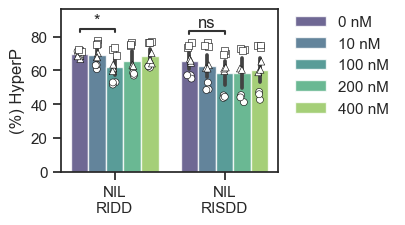

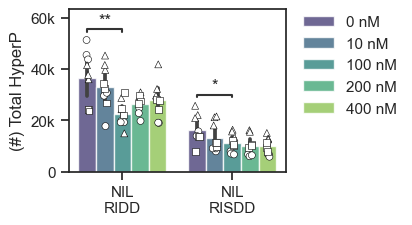

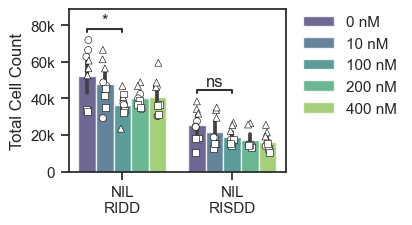

In [16]:
sns.set_theme(style="ticks",font_scale=1)

order = ['NIL RIDD','NIL RISDD']

pairs = [(('NIL RIDD', '0 nM'),('NIL RIDD','100 nM')),
          (('NIL RISDD', '0 nM'),('NIL RISDD','100 nM'))]

for i in data2plot:
    savetitle = 'RAS_' + i
    custom_barplot('infection',i,dataslice,savetitle,
                    order = order,
                    hue = 'concentration',
                    hue_order=['0 nM','10 nM','100 nM', '200 nM', '400 nM'],
                    palette='viridis',
                    height=2.5,
                    width=2.9,
                    xlabel_rot=0,
                    alpha=0.8,
                    reps='rep',
                    pairs=pairs)
    


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL_0 nM vs. NIL_100 nM: t-test independent samples, P_val:2.018e-02 t=-2.579e+00
NIL DD_0 nM vs. NIL DD_100 nM: t-test independent samples, P_val:6.003e-04 t=-4.259e+00
NIL SNAP-DD_0 nM vs. NIL SNAP-DD_100 nM: t-test independent samples, P_val:1.312e-06 t=-7.480e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL_0 nM vs. NIL_100 nM: t-test independent samples, P_val:5.700e-03 t=-3.190e+00
NIL DD_0 nM vs. NIL DD_100 nM: t-test independent samples, P_val:1.461e-05 t=-6.126e+00
NIL SNAP-DD_0 nM vs. NIL SNAP-DD_100 nM: t-test independent samples, P_val:1.248e-09 t=-1.242e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-

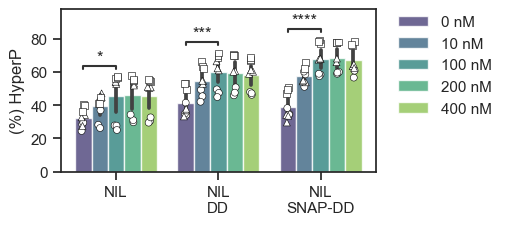

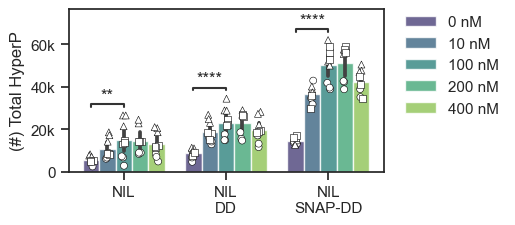

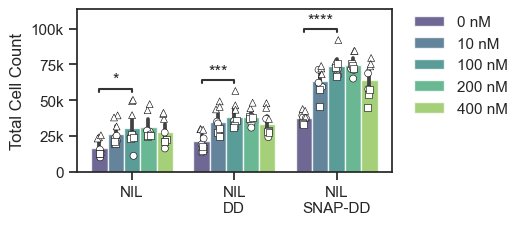

In [17]:
sns.set_theme(style="ticks",font_scale=1)

order = ['NIL','NIL DD','NIL SNAP-DD']

pairs = [(('NIL', '0 nM'),('NIL','100 nM')),
          (('NIL DD', '0 nM'),('NIL DD','100 nM')),
          (('NIL SNAP-DD', '0 nM'),('NIL SNAP-DD','100 nM'))]

for i in data2plot:
    savetitle = 'DD-Only_' + i
    custom_barplot('infection',i,dataslice,savetitle,
                    order = order,
                    hue = 'concentration',
                    hue_order=['0 nM','10 nM','100 nM', '200 nM', '400 nM'],
                    palette='viridis',
                    height=2.5,
                    width=4.2,
                    xlabel_rot=0,
                    alpha=0.8,
                    reps='rep',
                    pairs=pairs)
    


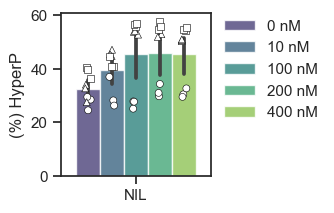

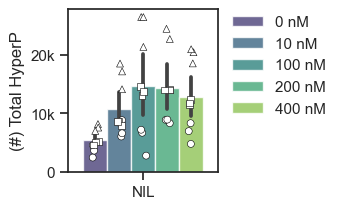

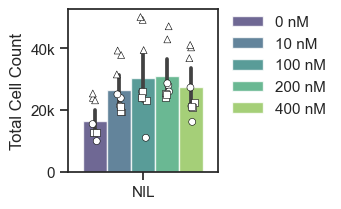

In [18]:
sns.set_theme(style="ticks",font_scale=1)

order = ['NIL']

for i in data2plot:
    savetitle = 'NIL-Only_' + i
    custom_barplot('infection',i,dataslice[dataslice.infection.isin(order)],savetitle,
                    order = order,
                    hue = 'concentration',
                    hue_order=['0 nM','10 nM','100 nM', '200 nM', '400 nM'],
                    palette='viridis',
                    height=2.5,
                    width=2,
                    xlabel_rot=0,
                    alpha=0.8,
                    reps='rep')
    


In [19]:
dataslice

slice = dataslice.drop(columns=['well','rep','condition'])

# Find the mean and standard error of the mean (SEM) for all technical and biological replicates in a given condition:
means = slice.groupby(['infection','concentration']).mean()
means.reset_index(drop=False,inplace=True) # Remove index

for infection_val in means['infection'].unique():
    norm_row = means[(means.infection == infection_val) & (means.concentration == '0 nM')]

    means.loc[(means['infection'] == infection_val),'(#) Total HyperP Fold Change'] = means.loc[
                    (means['infection'] == infection_val),'(#) Total HyperP'] / norm_row['(#) Total HyperP'].values[0]
    
    means.loc[(means['infection'] == infection_val),'(%) HyperP Fold Change'] = means.loc[
                    (means['infection'] == infection_val),'(%) HyperP'] / norm_row['(%) HyperP'].values[0]

display(means[means.concentration == '100 nM'])

,infection,concentration,(%) HyperP,(#) Total HyperP,Total Cell Count,(#) Total HyperP Fold Change,(%) HyperP Fold Change
2,NIL,100 nM,45.607771,14694.666667,30357.333333,2.741713,1.401852
7,NIL DD,100 nM,60.105218,23082.333333,38234.222222,2.669609,1.447504
12,NIL RIDD,100 nM,61.851516,22624.000000,36685.555556,0.620769,0.885951
17,NIL RISDD,100 nM,58.558085,11099.888889,18881.111111,0.680483,0.891676
22,NIL SNAP-DD,100 nM,68.050275,50222.888889,73701.444444,3.463303,1.743397


# Plot DD and SNAP-DD for figure 1

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL vs. NIL DD: t-test independent samples, P_val:1.436e-02 t=-2.746e+00
NIL DD vs. NIL SNAP-DD: t-test independent samples, P_val:5.160e-01 t=6.643e-01
NIL vs. NIL SNAP-DD: t-test independent samples, P_val:5.814e-02 t=-2.041e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL vs. NIL DD: t-test independent samples, P_val:3.215e-03 t=-3.461e+00
NIL DD vs. NIL SNAP-DD: t-test independent samples, P_val:6.807e-06 t=-6.540e+00
NIL vs. NIL SNAP-DD: t-test independent samples, P_val:6.880e-09 t=-1.103e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00

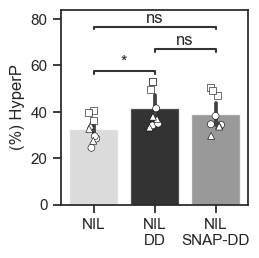

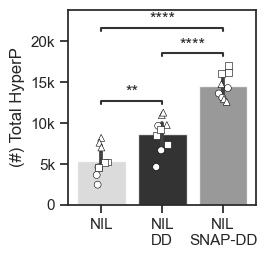

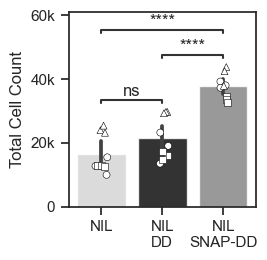

In [20]:
order = ['NIL','NIL DD','NIL SNAP-DD']
pairs = [('NIL','NIL DD'),
          ('NIL DD','NIL SNAP-DD'),
          ('NIL','NIL SNAP-DD')]

for i in data2plot:
    savetitle = 'DDvSDD_' + i
    custom_barplot('infection',i,dataslice[dataslice.concentration == '0 nM'],savetitle,
                    order = order,
                    palette={'NIL':'lightgray','NIL DD':'black','NIL SNAP-DD':'grey'},
                    height=3,
                    width=2.5,
                    xlabel_rot=0,
                    alpha=0.8,
                    reps='rep',
                    pairs=pairs)
